# Model for forecasting electricity market timeseries with a data-centric approach
This is a notebook for designing a data-centric approach towards forecasting electricity time series done as a part of a master thesis by

Albin Janzén - albja295@student.liu.se
Gustav Berling - gusbe498@studentliu.se

# Import libraries

In [66]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import dataset

In [67]:
og_df = pd.read_csv('data/Structured/all_data.csv')



C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [68]:
print(og_df.shape)

(202878, 503)


# Analyse data

In [69]:
# plot_cols = ['SE1']
# plot_features = og_df[plot_cols]
# plot_features.index = date_time
# _ = plot_features.plot(subplots=True)

In [70]:
# f = plt.figure(figsize=(20, 20))
# plt.matshow(og_df.corr().abs(), fignum=f.number)
# plt.xticks(range(og_df.select_dtypes(['number']).shape[1]), og_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
# plt.yticks(range(og_df.select_dtypes(['number']).shape[1]), og_df.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16)

# Parameters

In [71]:
# Select every n:th hour
n = 1

# How many hours into the future are we trying to predict?
OUT_STEPS = 1
# How many hours of past history do we want to use to predict the future?
input_width = 24
# How far into the future are we trying to predict?
shift = 1
# How far should we step forward in time when creating training examples?
sequence_stride = 1

lstm_units = 2
MAX_EPOCHS = 1000
batch_size = 128

# The patience parameter is the amount of epochs to check for improvement
patience = 3
# The minimum change in the validation loss to qualify as an improvement
min_delta = 0.001

# Number of plots to show results for
max_subplots = 6

# Cleanup data

In [72]:
# df = df[df.Unit == 'SEK']
# df = df[df.Alias == 'SE']

# corr = df.corr().abs()
# x = corr['SE1'].sort_values(ascending=True)
# x = x[x > 0.2]
# print(x)

df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)
# df.loc[:,['Summa gas/Diesel']] = df.loc[:,['Summa gas/Diesel']].replace('-', np.nan)
# df.loc[:,['Summa gas/Diesel']] = df.loc[:,['Summa gas/Diesel']].replace('            ', np.nan)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
# percent_missing = df.isnull().sum() * 100 / len(df)
# x = percent_missing.sort_values()
# print(x)

# df = df.drop('SE2', axis=1)
# df = df.drop('SE3', axis=1)
# df = df.drop('SE4', axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)
df = df.iloc[:,0:2]

# print(df[df['Summa gas/Diesel'] < 0 ])
# print(df.columns[80])
# print(df.iloc[:,80].unique())
# print(df.iloc[:,80].nunique())
# plot_features = df.iloc[:,80]
# plot_features.index = date_time
# _ = plot_features.plot(subplots=True)
# print(df.iloc[:,1:-1].dtypes.unique())
# df = df.drop(df.columns[80], axis=1)
# df = df.drop(df.columns[92], axis=1)
# df = df.drop(df.columns[97], axis=1)
# df = df.drop(df.columns[98], axis=1)
# df = df.drop(df.columns[99], axis=1)
# df = df.drop(df.columns[100:250], axis=1)
print(df.head())

c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


                  Date     SE1
0  2000-01-01 00:00:00  133.95
1  2000-01-01 01:00:00  133.95
2  2000-01-01 02:00:00  133.95
3  2000-01-01 03:00:00  133.95
4  2000-01-01 04:00:00  133.95


C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if await self.run_code(code, result, async_=asy):


In [73]:
print(df.iloc[:,1:].dtypes.unique())
g = df.columns.groupby(df.dtypes)
print(g)
# df.apply(pd.to_numeric)
# print(df.loc[:,['Summa gas/Diesel']])

[dtype('float64')]
{float64: ['SE1'], object: ['Date']}


Use every n:th hour

In [74]:
print(df.size)
# 2 = 12 hours / day
# 3 = 8 hours / day
# 4 = 6 hours / day
# 6 = 4 hours / day
# 12 = 2 hours / day
# 24 = 1 hour / day
# 48 = every other day
df = df.iloc[::n, :]
print(df.size)

405756
405756


Pop dates

In [75]:

date_time = pd.to_datetime(df.pop('Date'), format='%Y.%m.%d %H:%M:%S')

Convert time to seconds

In [76]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Augment data

## Create fourier features

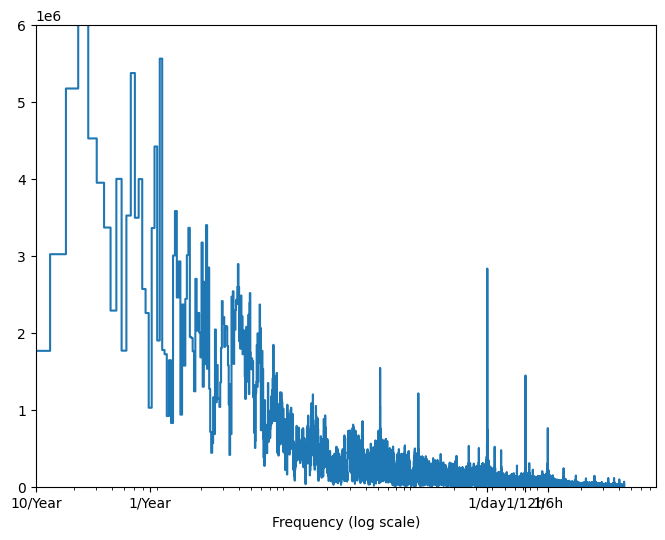

In [77]:
fft = tf.signal.rfft(df['SE1'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df['SE1']) 
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 6000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([0.1, 0.8, 365.2524, 365.2524*2, 365.2524*3], labels=['10/Year','1/Year', '1/day', '1/12h', '1/6h'])
_ = plt.xlabel('Frequency (log scale)')

In [78]:
day = 24*60*60
day_half = day/2
day_quarter = day_half/2
year_and_quarter = 1.26*(365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Day half sin'] = np.sin(timestamp_s * (2 * np.pi / day_half))
df['Day half cos'] = np.cos(timestamp_s * (2 * np.pi / day_half))
df['Day quarter sin'] = np.sin(timestamp_s * (2 * np.pi / day_quarter))
df['Day quarter cos'] = np.cos(timestamp_s * (2 * np.pi / day_quarter))
df['Year and quarter sin'] = np.sin(timestamp_s * (2 * np.pi / year_and_quarter))
df['Year and quarter cos'] = np.cos(timestamp_s * (2 * np.pi / year_and_quarter))
df['relative_day'] = date_time.dt.dayofyear
df['relative_hour'] = date_time.dt.hour

# Split data

In [79]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
test_df = df[int(n*0.9):]
val_df = df[int(n*0.7):int(n*0.9)]
train_df = df[0:int(n*0.7)]

num_features = df.shape[1]

# Normalize data

In [80]:
for e in df.columns:
    if train_df[e].nunique() == 1:
        train_df = train_df.drop(e, axis=1)
        val_df = val_df.drop(e, axis=1)
        test_df = test_df.drop(e, axis=1)
        df = df.drop(e, axis=1)
        
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


# Analyse preprocessed data

In [81]:
# df_std = df
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')

# print(df_std[df_std.isnull() == True].count())

# plt.figure(figsize=(12, 6))
# print(df_std)
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

# Forecasting model

## Window generator

In [82]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
        
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='SE1', max_subplots=max_subplots):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
  def make_dataset(self, data, sequence_stride=sequence_stride, batch_size=batch_size):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=sequence_stride,
        shuffle=False,
        batch_size=batch_size)
    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.val))
      # And cache it for next time
      self._example = result
    return result



## Learning plot

In [83]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

## Model setup

In [84]:
def compile_and_fit(model, window, patience=patience):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, PlotLearning()])
  return history

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['SE1']

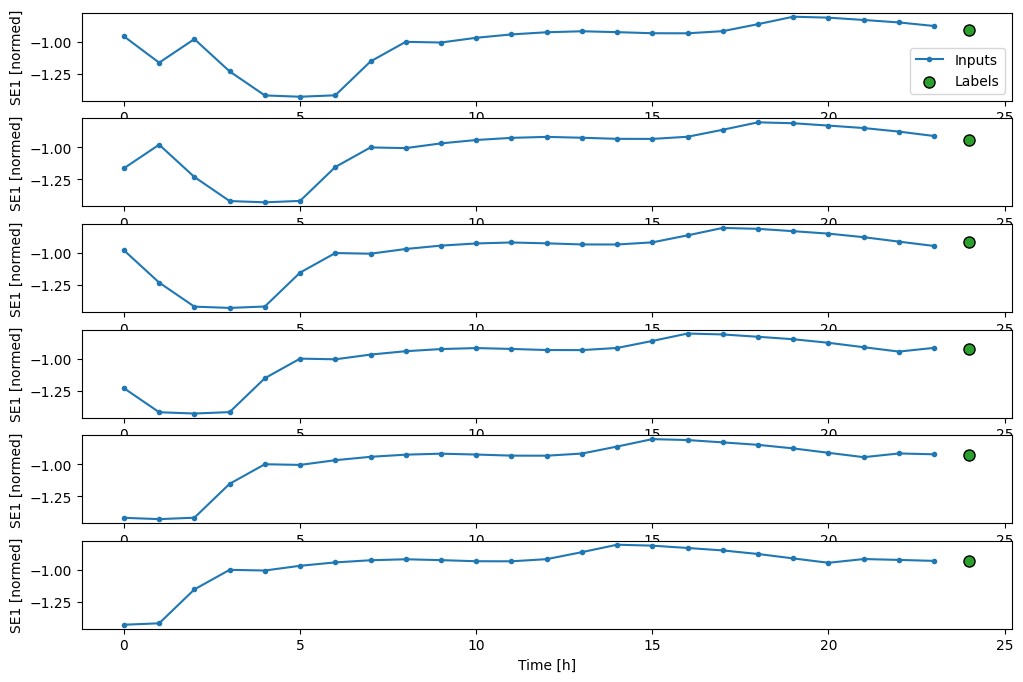

In [85]:
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=shift,
                               label_columns=['SE1'])
print(multi_window.train)

multi_window.plot()
multi_window

## Train model

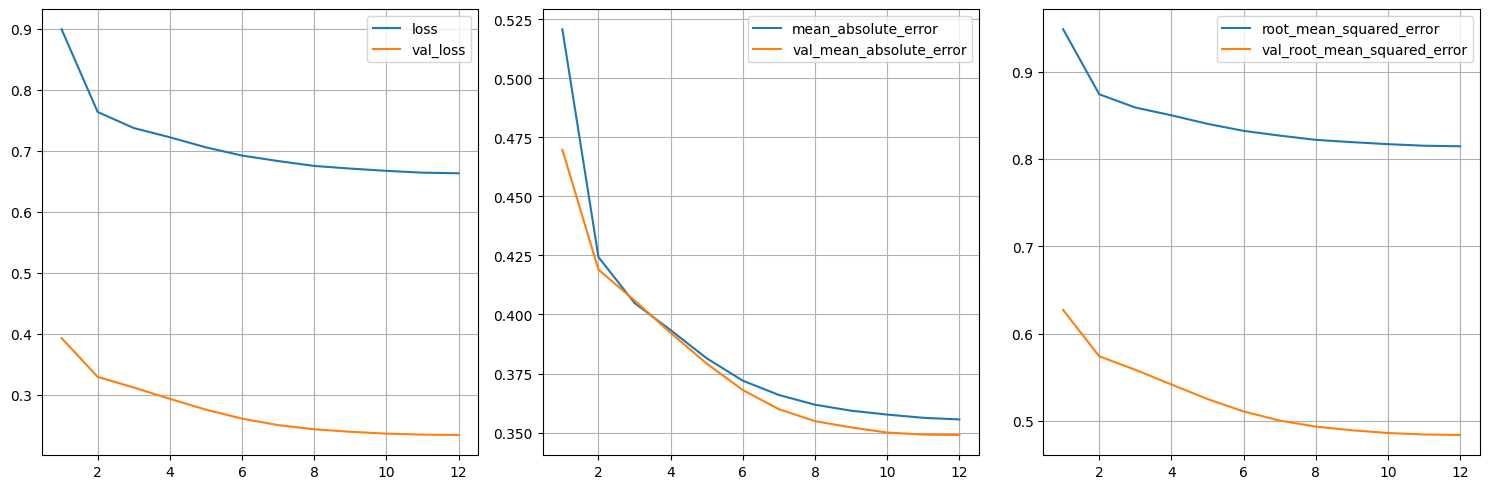

1110/1110 [==============================] - 23s 21ms/step - loss: 0.6633 - mean_absolute_error: 0.3556 - root_mean_squared_error: 0.8144 - val_loss: 0.2341 - val_mean_absolute_error: 0.3490 - val_root_mean_squared_error: 0.4839
Epoch 13/1000
 268/1110 [======>.......................] - ETA: 14s - loss: 0.3223 - mean_absolute_error: 0.3555 - root_mean_squared_error: 0.5677

KeyboardInterrupt: 

In [86]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(lstm_units, return_sequences=True, batch_size=batch_size),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Batchnormalization(),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(1,
                          kernel_initializer=tf.initializers.zeros(), bias_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance = multi_lstm_model.evaluate(multi_window.val)
multi_performance = multi_lstm_model.evaluate(multi_window.test, verbose=0)
print(multi_val_performance)
print(multi_performance)
multi_window.plot(multi_lstm_model)

## Model evaluation

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 64)                31488     
                                                                 
 dense_27 (Dense)            (None, 1416)              92040     
                                                                 
 reshape_27 (Reshape)        (None, 24, 59)            0         
                                                                 
Total params: 123,528
Trainable params: 123,528
Non-trainable params: 0
_________________________________________________________________


{'name': 'sequential_27',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 24, 58),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lstm_27_input'}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm_27',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 64,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    '

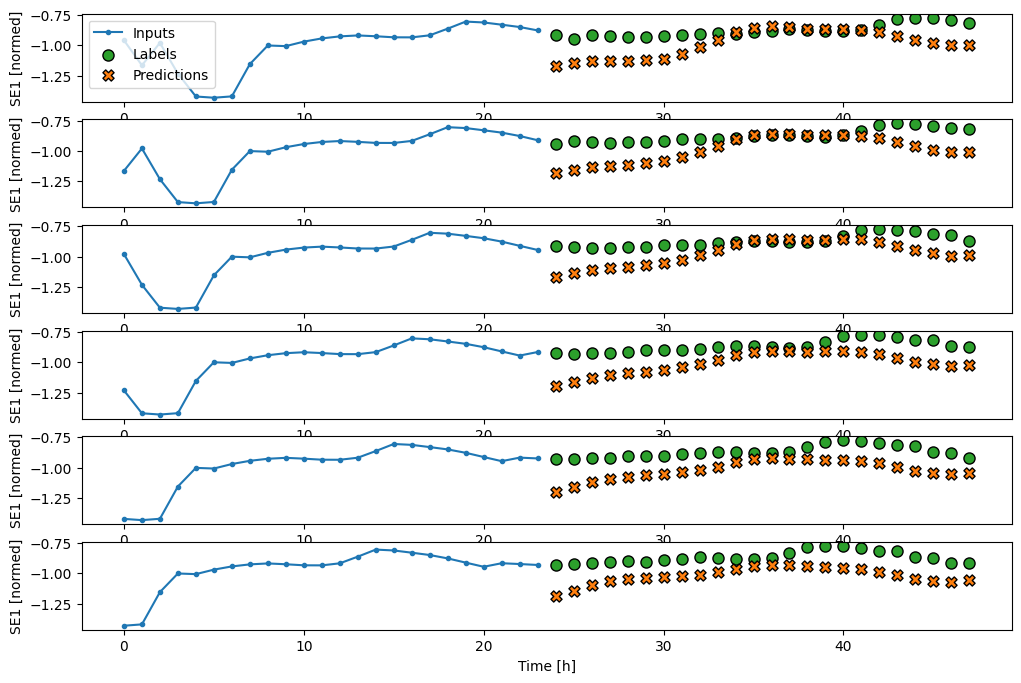

In [ ]:
multi_window.plot(multi_lstm_model)
multi_lstm_model.summary()
# # multi_lstm_model.get_weights()
multi_lstm_model.get_config()
# for layer in multi_lstm_model.layers: print(layer.get_config(), layer.get_weights())